In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.linalg as la
%matplotlib inline
plt.rcParams['figure.figsize'] = 15,10

In [8]:
image_data = pd.read_csv("./pokemon_image.csv")
image_data.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [169]:
stats_data = pd.read_csv("./pokemon_stats.csv")
stats_data['name'] = stats_data['name'].apply(lambda row: row.lower())
print(stats_data.columns)
stats_data.head()

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


# Data Preparation: Getting the top 3 colors per image 

In [41]:
import imageio
import os
from colorthief import ColorThief

In [ ]:
# CODE FOR PLOTTING 
#     construct the color compressed version of X
#     X_color_compressed = np.zeros(X.shape)
#     X_color_compressed = centers[labels,:]

#     # reshape the color compressed version of X
#     X_ccompressed = X_color_compressed.reshape((r,c,3))

#     # show the pictures side by side
#     # Two subplots, unpack the axes array immediately
#     f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#     ax1.imshow(pokemon)
#     ax2.imshow(X_ccompressed)

In [78]:
directory = os.fsencode("./images")

color1 = []
color2 = []
color3 = []
names = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".png"): 
        full_filename = "./images/" + filename
        names.append(filename[:-4])
        color_thief = ColorThief(full_filename)
        palette = color_thief.get_palette(color_count=3)
        color1.append(palette[0])
        color2.append(palette[1])
        color3.append(palette[2])
    else:
        continue 

In [232]:
colors = pd.DataFrame({"name":names, "color1":color1, "color2":color2, "color3":color3})
colors.head()

,name,color1,color2,color3
0,parasect,"(225, 173, 86)","(94, 63, 41)","(250, 198, 233)"
1,lumineon,"(55, 79, 86)","(189, 234, 231)","(180, 141, 163)"
2,raikou,"(195, 173, 90)","(60, 54, 45)","(219, 201, 211)"
3,dedenne,"(196, 162, 87)","(40, 38, 34)","(218, 215, 188)"
4,pyroar,"(198, 96, 71)","(243, 205, 131)","(84, 76, 69)"


In [81]:
import webcolors

# Source: https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

# requested_colour = (119, 172, 152)
# actual_name, closest_name = get_colour_name(requested_colour)

# print "Actual colour name:", actual_name, ", closest colour name:", closest_name

In [233]:
colors['webcolor1'] = colors['color1'].apply(lambda row: get_colour_name(row)[1])
colors['webcolor2'] = colors['color2'].apply(lambda row: get_colour_name(row)[1])
colors['webcolor3'] = colors['color3'].apply(lambda row: get_colour_name(row)[1])
colors.head()

,name,color1,color2,color3,webcolor1,webcolor2,webcolor3
0,parasect,"(225, 173, 86)","(94, 63, 41)","(250, 198, 233)",sandybrown,darkolivegreen,pink
1,lumineon,"(55, 79, 86)","(189, 234, 231)","(180, 141, 163)",darkslategrey,paleturquoise,rosybrown
2,raikou,"(195, 173, 90)","(60, 54, 45)","(219, 201, 211)",darkkhaki,darkslategrey,thistle
3,dedenne,"(196, 162, 87)","(40, 38, 34)","(218, 215, 188)",darkkhaki,darkslategrey,lightgrey
4,pyroar,"(198, 96, 71)","(243, 205, 131)","(84, 76, 69)",indianred,khaki,darkolivegreen


In [234]:
color_categories = pd.read_csv("./colors.csv")
color_categories['webcolor'] = color_categories['webcolor'].apply(lambda row: str(row).strip())
color_categories['category'] = color_categories['category'].apply(lambda row: str(row).strip())
color_categories.head()

,category,webcolor
0,pink,pink
1,pink,lightpink
2,pink,hotpink
3,pink,deeppink
4,pink,palevioletred


In [235]:
cat1 = pd.merge(colors, color_categories, left_on=['webcolor1'], right_on=['webcolor'], how="left")
cat1 = cat1.drop(['webcolor'], axis=1)
cat1 = cat1.rename({'category': 'category1'}, axis=1)

cat2 = pd.merge(cat1, color_categories, left_on=['webcolor2'], right_on=['webcolor'], how="left")
cat2 = cat2.drop(['webcolor'], axis=1)
cat2 = cat2.rename({'category': 'category2'}, axis=1)

colors = pd.merge(cat2, color_categories, left_on=['webcolor3'], right_on=['webcolor'], how="left")
colors = colors.drop(['webcolor'], axis=1)
colors = colors.rename({'category': 'category3'}, axis=1)

print(cat1.shape)
print(cat2.shape)
print(colors.shape)
colors.head()

(721, 8)
(721, 9)
(721, 10)


,name,color1,color2,color3,webcolor1,webcolor2,webcolor3,category1,category2,category3
0,parasect,"(225, 173, 86)","(94, 63, 41)","(250, 198, 233)",sandybrown,darkolivegreen,pink,brown,green,pink
1,lumineon,"(55, 79, 86)","(189, 234, 231)","(180, 141, 163)",darkslategrey,paleturquoise,rosybrown,grey,cyan,brown
2,raikou,"(195, 173, 90)","(60, 54, 45)","(219, 201, 211)",darkkhaki,darkslategrey,thistle,yellow,grey,purple
3,dedenne,"(196, 162, 87)","(40, 38, 34)","(218, 215, 188)",darkkhaki,darkslategrey,lightgrey,yellow,grey,grey
4,pyroar,"(198, 96, 71)","(243, 205, 131)","(84, 76, 69)",indianred,khaki,darkolivegreen,red,yellow,green


In [236]:
colors3 = colors[['name', 'category1', 'category2', 'category3']]
colors3.head()

,name,category1,category2,category3
0,parasect,brown,green,pink
1,lumineon,grey,cyan,brown
2,raikou,yellow,grey,purple
3,dedenne,yellow,grey,grey
4,pyroar,red,yellow,green


In [237]:
alldata = pd.merge(colors3, image_data, left_on="name", right_on="Name", how="inner")
alldata = alldata.drop(['Name'], axis=1)
alldata.head()

,name,category1,category2,category3,Type1,Type2
0,parasect,brown,green,pink,Bug,Grass
1,lumineon,grey,cyan,brown,Water,NaN
2,raikou,yellow,grey,purple,Electric,NaN
3,dedenne,yellow,grey,grey,Electric,Fairy
4,pyroar,red,yellow,green,Fire,Normal


# EDA 
- colors per type 
- battle stats per type 
    - is there a type with the highest HP?
    

In [238]:
# Get the count of each color per type of pokemon
type_counts = {}
for poke_type in types: 
    c1 = alldata[alldata['Type1'] == poke_type].groupby(alldata['category1']).count().category1
    c2 = alldata[alldata['Type1'] == poke_type].groupby(alldata['category2']).count().category2
    c3 = alldata[alldata['Type1'] == poke_type].groupby(alldata['category3']).count().category3
    counts = c1.add(c2, c3, fill_value=0)
    type_counts[poke_type] = counts

blue       3.0
brown     27.0
green     15.0
grey      61.0
pink       2.0
purple     2.0
red        6.0
white      1.0
yellow     9.0
dtype: float64
blue      41.0
brown     34.0
cyan       5.0
green      8.0
grey      93.0
pink       1.0
purple     9.0
red        5.0
white      1.0
yellow    11.0
dtype: float64
blue       7.0
brown     13.0
green      3.0
grey      36.0
purple     3.0
yellow    10.0
dtype: float64
blue       1.0
brown     37.0
green      4.0
grey      25.0
red        9.0
white      1.0
yellow    17.0
dtype: float64
blue      16.0
brown      8.0
green      1.0
grey      18.0
purple     1.0
red        1.0
dtype: float64
category1
blue       4
brown     20
green     35
grey      49
pink       2
purple     3
red        3
yellow    16
dtype: int64
blue       3.0
brown      6.0
green      3.0
grey      28.0
pink       1.0
purple     1.0
red        1.0
yellow     2.0
dtype: float64
blue       9.0
brown     52.0
cyan       1.0
green      9.0
grey      87.0
pink       4.0
pur

In [242]:
type_counts_df = pd.DataFrame(type_counts)
type_counts_df = type_counts_df.fillna(0)
type_counts_df

,Bug,Water,Electric,Fire,Ice,Grass,Ghost,Normal,Ground,Psychic,Dark,Dragon,Rock,Fighting,Poison,Flying,Fairy,Steel
blue,3.0,41.0,7.0,1.0,16.0,4.0,3.0,9.0,4.0,8.0,5.0,6.0,7.0,3.0,2.0,0.0,0.0,5.0
brown,27.0,34.0,13.0,37.0,8.0,20.0,6.0,52.0,12.0,8.0,9.0,7.0,8.0,15.0,3.0,1.0,6.0,1.0
cyan,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
green,15.0,8.0,3.0,4.0,1.0,35.0,3.0,9.0,4.0,7.0,1.0,4.0,7.0,0.0,8.0,2.0,1.0,3.0
grey,61.0,93.0,36.0,25.0,18.0,49.0,28.0,87.0,28.0,54.0,30.0,24.0,52.0,27.0,37.0,3.0,21.0,30.0
pink,2.0,1.0,0.0,0.0,0.0,2.0,1.0,4.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
purple,2.0,9.0,3.0,0.0,1.0,3.0,1.0,6.0,0.0,8.0,2.0,3.0,0.0,1.0,3.0,0.0,3.0,1.0
red,6.0,5.0,0.0,9.0,1.0,3.0,1.0,6.0,4.0,3.0,5.0,2.0,4.0,2.0,1.0,0.0,1.0,0.0
white,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
yellow,9.0,11.0,10.0,17.0,0.0,16.0,2.0,10.0,7.0,3.0,2.0,1.0,4.0,1.0,0.0,0.0,1.0,4.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a285ebba8>,
      dtype=object)

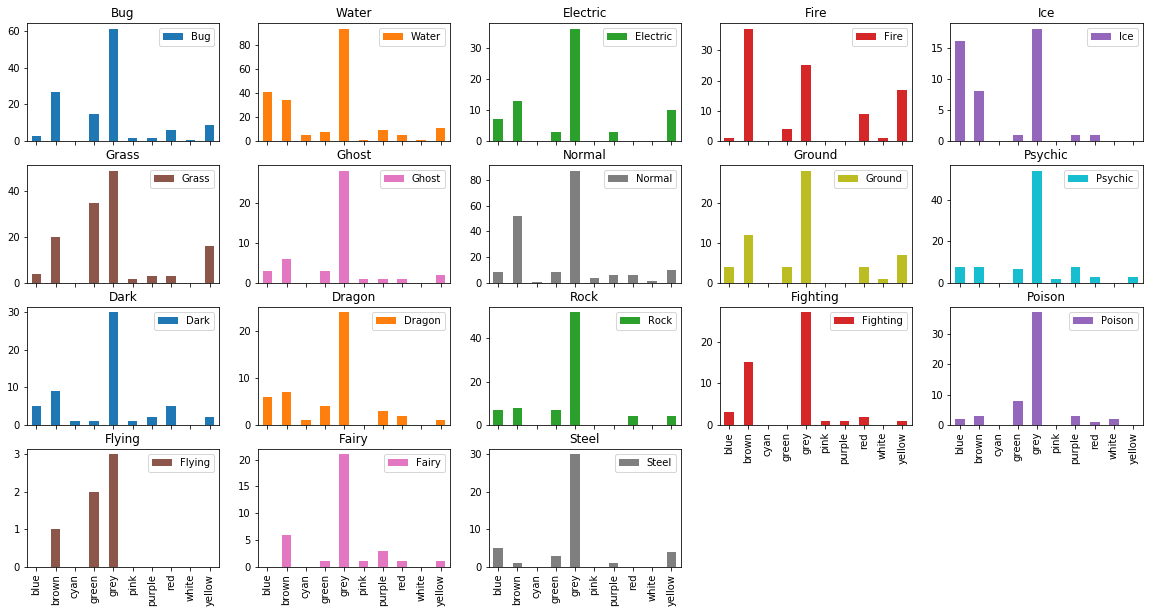

In [255]:
type_counts_df.plot(kind="bar", subplots = True, layout=(4,5), figsize=(20,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a291030f0>,
      dtype=object)

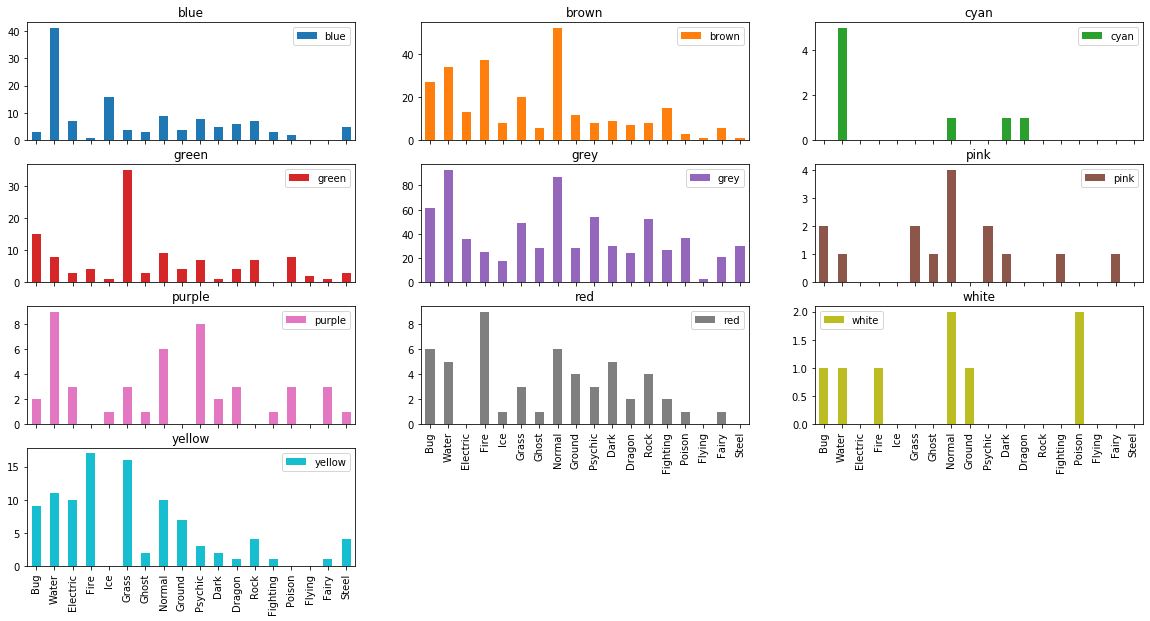

In [258]:
flipped = type_counts_df.transpose()
flipped.plot(kind="bar", subplots = True, layout=(4,3), figsize=(20,10))